# Let's measure some rotation periods of CVZ stars!

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import lightcurvestuff as lcs
import starspot as ss
from tqdm import trange
import starspot.rotation_tools as rt

Load the catalogs.

In [3]:
fn = glob.glob("/Users/rangus/projects/TESSlightcurves/*fits")

In [13]:
import re

def extract_ticid(fn):
    return int(re.findall(r'\d+', fn)[2])

In [128]:
ticid = extract_ticid(fn[5])  # 2
print(ticid)

ticid = 149107360
ticid = 294274438

path = "/Users/rangus/projects/TESSlightcurves/"
str_ticid = str(int(ticid)).zfill(16)
tfile = "tess?????????????-s????-{}-????-s_lc.fits".format(str_ticid)

ticpath = os.path.join(path, tfile)
fnames = sorted(glob.glob(ticpath))
time, flux, flux_err = lcs.tools.load_and_split_TESS(fnames)
print(len(time), "sectors")

# print(flux[3])
# plt.plot(time[3], flux[3])

# time.pop(3)
# flux.pop(3)
# flux_err.pop(3)

55296056
12 sectors


Sigma clip each sector.

In [129]:
def sigma_clip_TESS_sector(x, y, yerr):
    x, y, yerr = np.array(x), np.array(y), np.array(yerr)
    
    # Initial removal of extreme outliers.
    m = rt.sigma_clip(y, nsigma=7)
    x, y, yerr = x[m], y[m], yerr[m]

    # Remove outliers using Sav-Gol filter
    smooth, mask = rt.filter_sigma_clip(x, y)
    resids = y - smooth
    stdev = np.std(resids)
    return x[mask], y[mask], yerr[mask], stdev

x, y, yerr, std = [], [], [], []
for i in trange(len(time)):
    t, f, ferr, stdev = sigma_clip_TESS_sector(time[i], flux[i], flux_err[i])
    x.append(t)
    y.append(f)
    yerr.append(ferr)
    std.append(stdev)

  0%|          | 0/12 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
100%|██████████| 12/12 [00:02<00:00,  3.89it/s]


Find gap times and step offsets.

In [130]:
def find_gap_times(time):
    
    start_times, stop_times = [], []
    for i in range(len(time)):
        start_times.append(min(time[i]))
        stop_times.append(max(time[i]))
    
    return start_times[1:]

gap_times = find_gap_times(x)

def find_steps(y):
    # Meds
    meds = []
    for i in range(len(y)):
        meds.append(np.median(y[i]))
    return meds[1:]

original_flux_median = np.median(y[0])
y -= original_flux_median
steps = find_steps(y)

Format light curves.

In [131]:
def format_lc(t, y, yerr, subsample=10):
    
    # turn into arrays
    t = np.array([i for j in x for i in j], dtype="float64")
    y = np.array([i for j in y for i in j], dtype="float64")
    yerr = np.array([i for j in yerr for i in j], dtype="float64")

    # Remove NaNs
    m = np.isfinite(t) * np.isfinite(y) * np.isfinite(yerr)
    t, y, yerr = t[m], y[m], yerr[m]

    # Subsample
    t, y, yerr = t[::subsample], y[::subsample], yerr[::subsample]

    # Sort by time
    inds = np.argsort(t)
    t, y, yerr = t[inds], y[inds], yerr[inds]

    return t, y, yerr

t, y, yerr = format_lc(x, y, yerr)

# Start at time 0
gap_times -= t[0]
t -= t[0]

[8.752777, 27.172424, 7.7496033, 12.294189, -3.4752808, -25.255432, 6.0644226, -13.275955, -9.096741, 8.99353, -3.9085083]


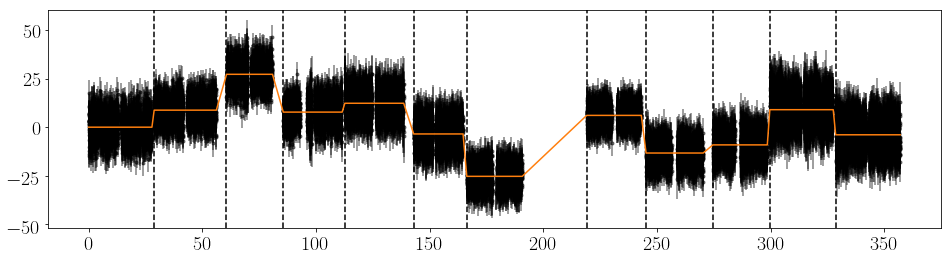

In [132]:
plt.figure(figsize=(16, 4))
plt.errorbar(t, y, yerr=yerr, fmt="k.", alpha=.5)

from starspot.stitch import step_model

mu = step_model(t, gap_times, steps)
print(steps)
plt.plot(t, mu, "C1", zorder=10)

for g in gap_times:
    plt.axvline(g, color="k", ls="--")

Find the offsets:

In [133]:
import starspot.stitch as sps

star = sps.StitchModel(t, y, yerr, gap_times, steps, 2.0)
star.model_offsets()
map_soln = star.find_optimum()

# Correct the light curve
best_fit_mu = step_model(t, gap_times, steps)
corrected_y = y - best_fit_mu

success: False
initial logp: -138039.74684789483
final logp: -130523.3722273464


Median-normalize light curve.

In [134]:
corrected_y /= original_flux_median

/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
100%|██████████| 1000/1000 [00:04<00:00, 235.88it/s]


Rvar =  2440.368016373513 ppm


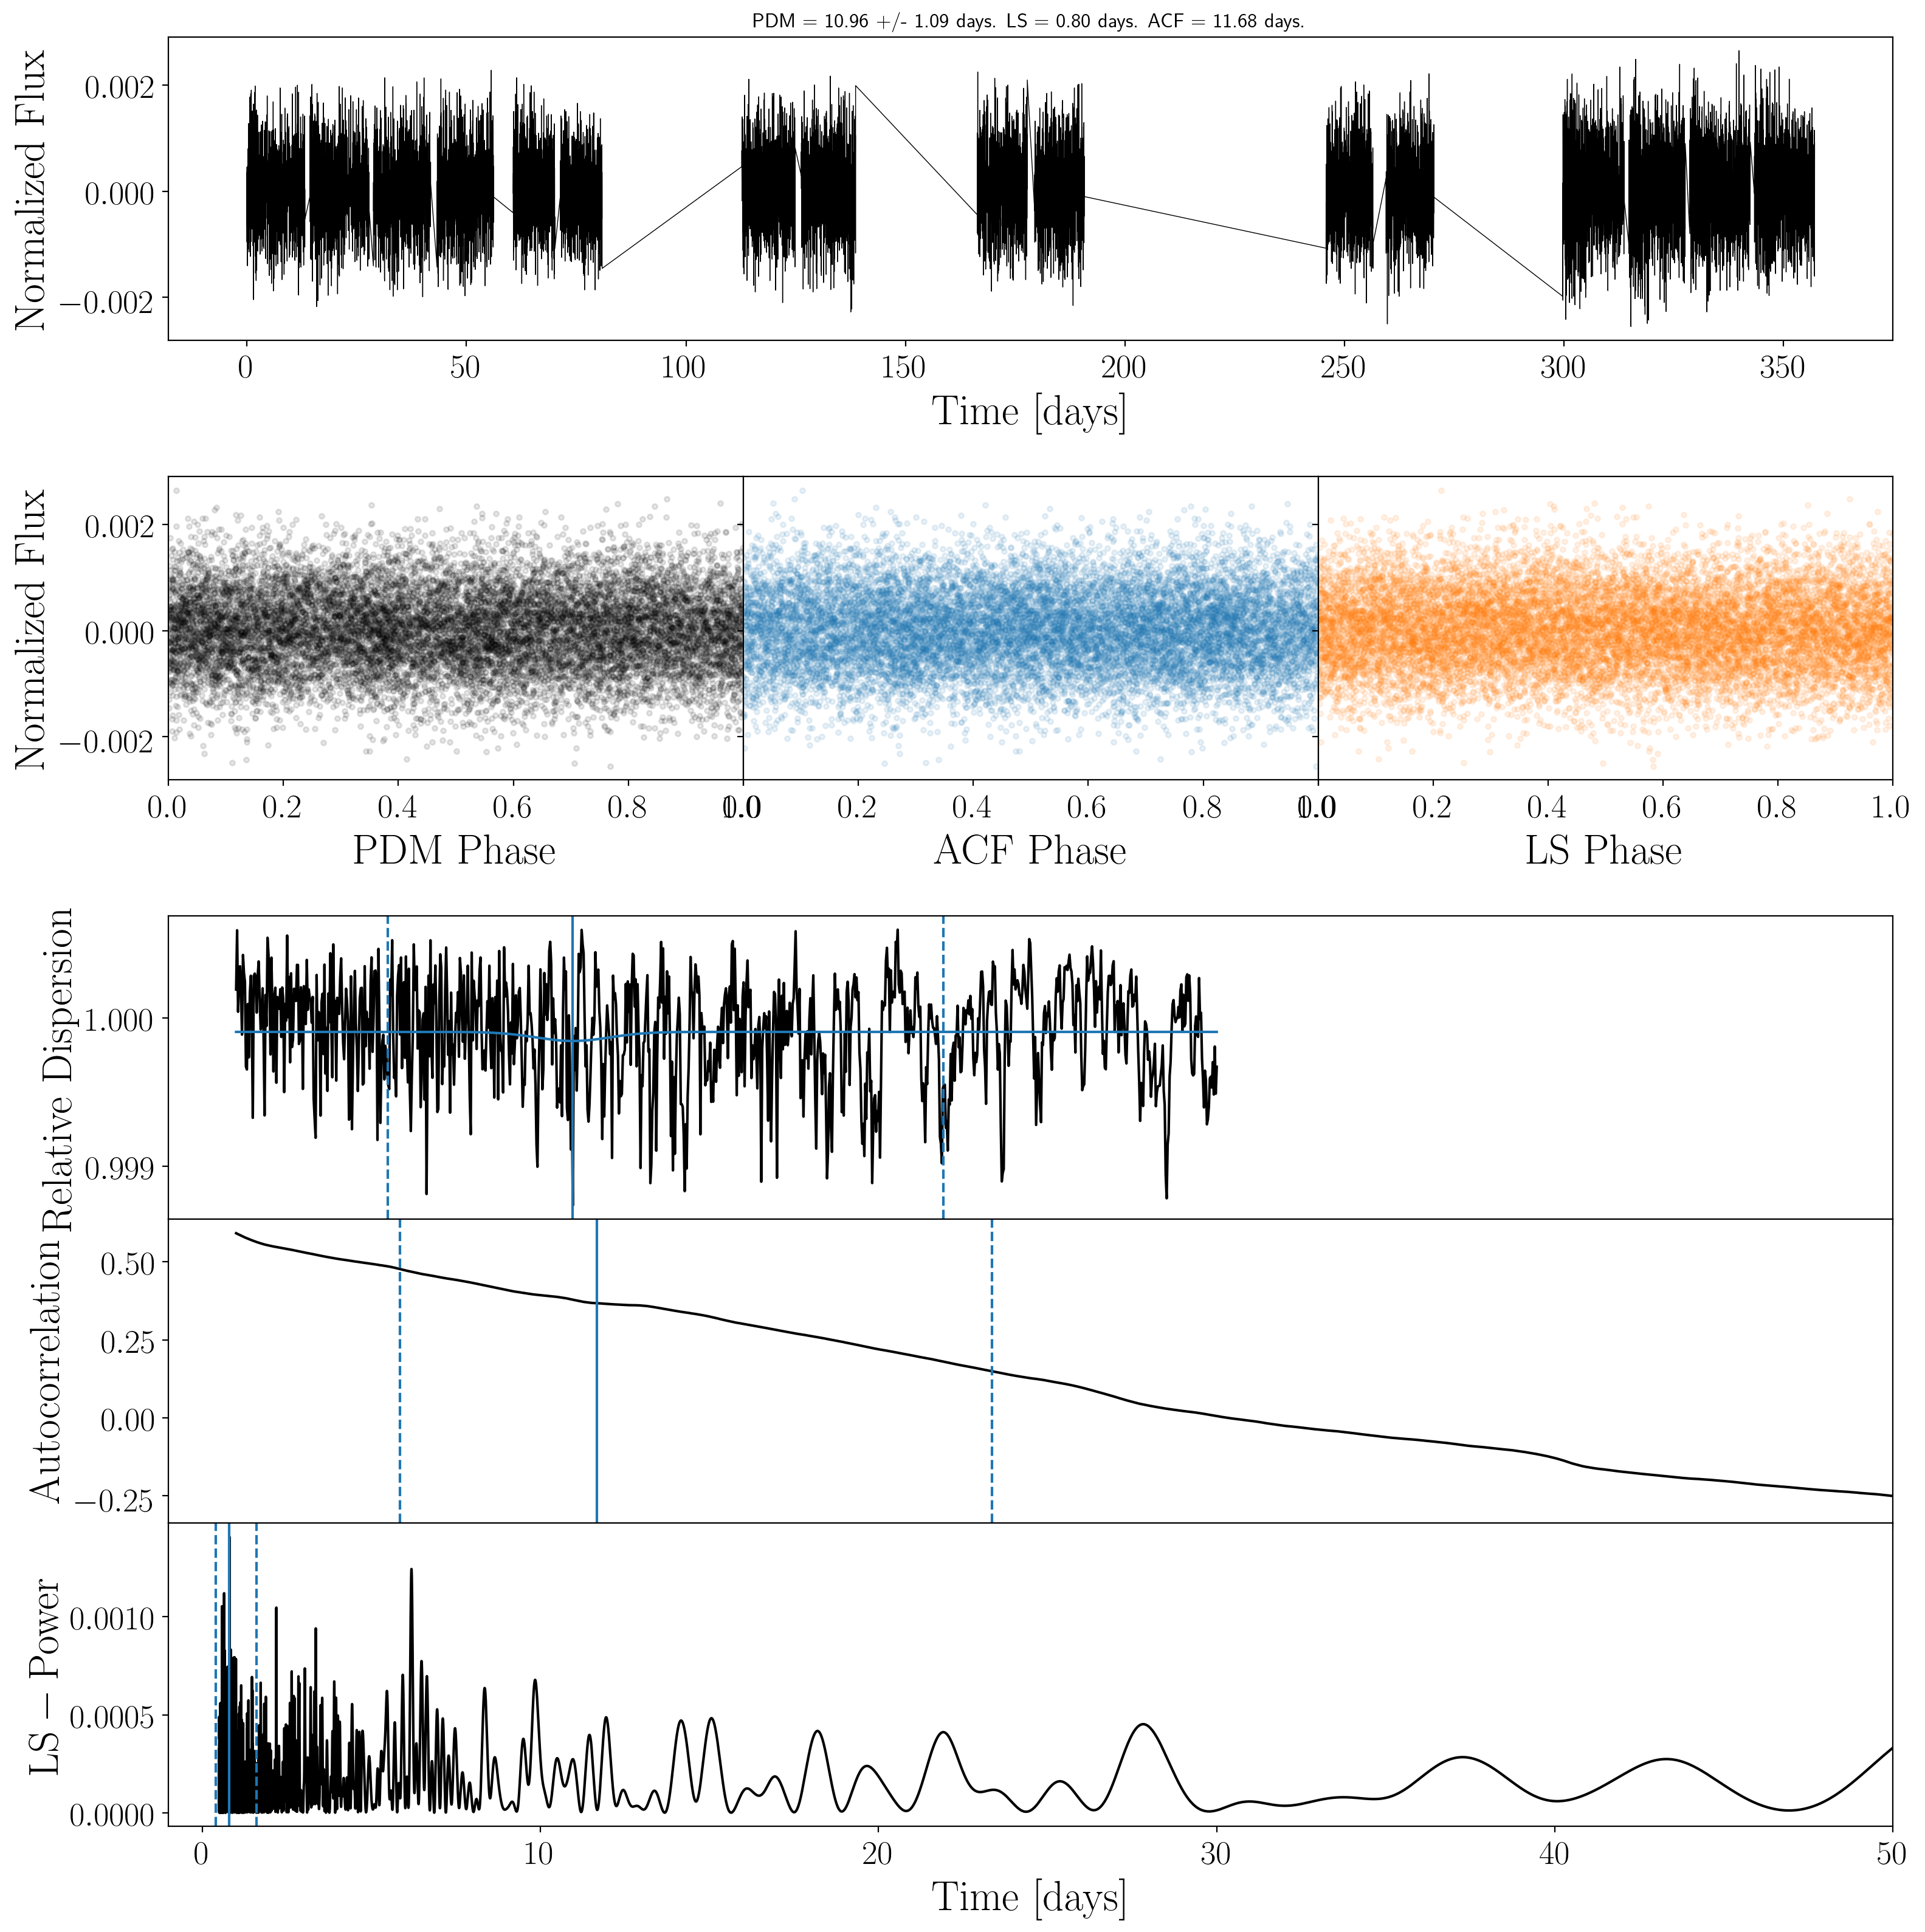

In [127]:
rotate = ss.RotationModel(t, corrected_y, yerr)
ls_period = rotate.ls_rotation()

def myround(x, base=5):
    return int(base * round(float(x)/base))

acf_period = rotate.acf_rotation(interval=0.00138889, cutoff=1, window_length=999)
# fig = rotate.big_plot(methods=["acf", "ls"], xlim=(-1, 50));

period_grid = np.linspace(1, 30, 1000)
pdm_period = rotate.pdm_rotation(period_grid)
fig = rotate.big_plot(methods=["pdm", "acf", "ls"], xlim=(-1, 50));

print("Rvar = ", rotate.Rvar*1e6, "ppm")

In [109]:
# fig = plt.figure(figsize=(16, 12), dpi=200)

# ax1 = fig.add_subplot(311)
# ax1.plot(x, y+1, "k.", alpha=.1, rasterized=True)
# ax1.set_ylabel("Normalized Flux")
# ax1.set_xlim(0, max(x))

# ax2 = fig.add_subplot(312)
# ax2.plot(x, y+1, "k.", alpha=.1, rasterized=True)
# ax2.set_xlim(0, 100)
# ax2.set_ylabel("Normalized Flux")

# ax3 = fig.add_subplot(313)
# ax3.plot(x, y+1, "k.", alpha=.1, rasterized=True)
# ax3.set_xlim(0, 30)
# ax3.set_xlabel("Time [days]")
# ax3.set_ylabel("Normalized Flux");

Don't calculate ACF because there are so many missing sectors, it won't work very well. Instead, calculate ACF for every sector individually.

In [110]:
x, y, yerr = lcs.tools.load_and_split_TESS(fnames)

In [111]:
from tqdm import trange
acfs, lags = [], []
for i in trange(len(x)):
    star = ss.RotationModel(x[i], y[i], yerr[i])
    acf_period = star.acf_rotation(interval="TESS", smooth=9, cutoff=1.2)
    acfs.append(star.acf)
    lags.append(star.lags)

100%|██████████| 12/12 [00:00<00:00, 64.38it/s]


In [8]:
from scipy.signal import savgol_filter
from starspot.rotation_tools import get_peak_statistics

100%|██████████| 12/12 [00:00<00:00, 78.46it/s]


7.655561680000001


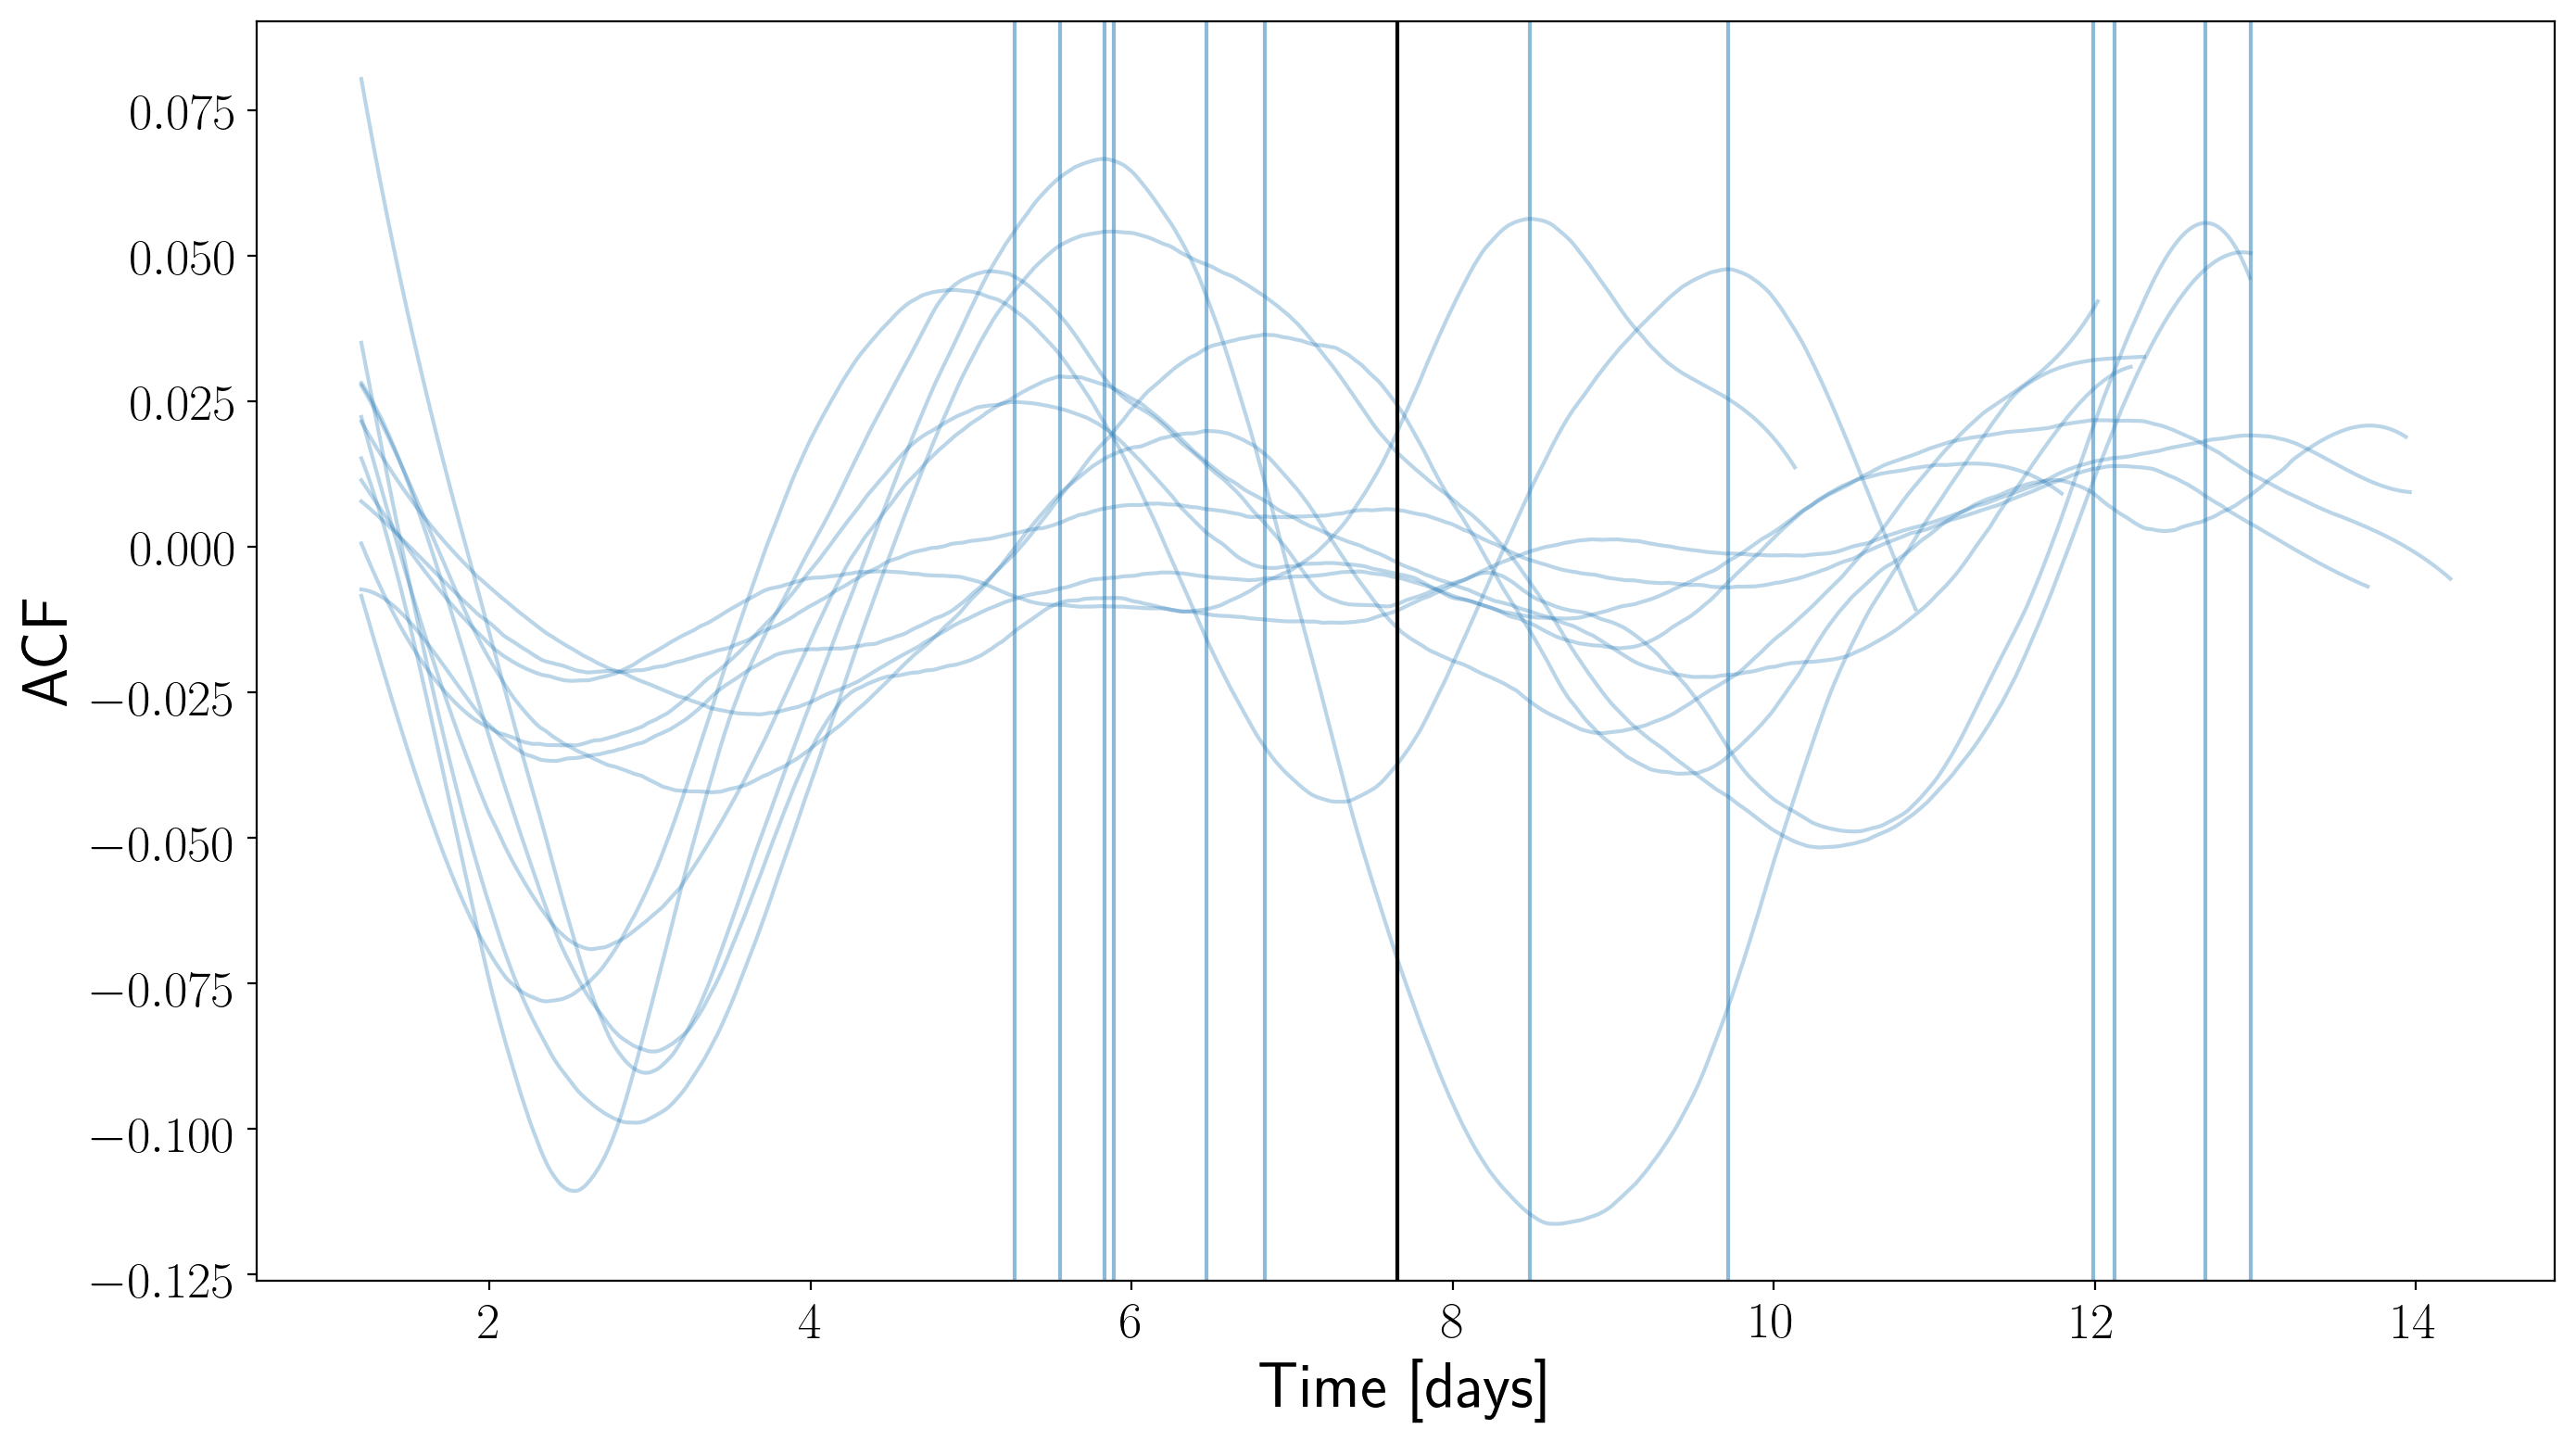

In [11]:
fig = plt.figure(figsize=(16, 9), dpi=200)
xp = np.linspace(0, 14, 1000)
smooth_tot, peaks = np.zeros_like(xp), []
for i in trange(len(acfs)):
    smooth = savgol_filter(acfs[i], 1001, 3)
    xpeak, ypeak = get_peak_statistics(lags[i], smooth)
    peaks.append(xpeak[0])
    plt.axvline(xpeak[0], alpha=.5)
    plt.plot(lags[i], smooth, "C0", alpha=.3)
    y = np.interp(xp, lags[i], smooth)
    smooth_tot += y
plt.xlabel("Time [days]")
plt.ylabel("ACF");
plt.axvline(np.median(peaks), color="k")
print(np.median(peaks))

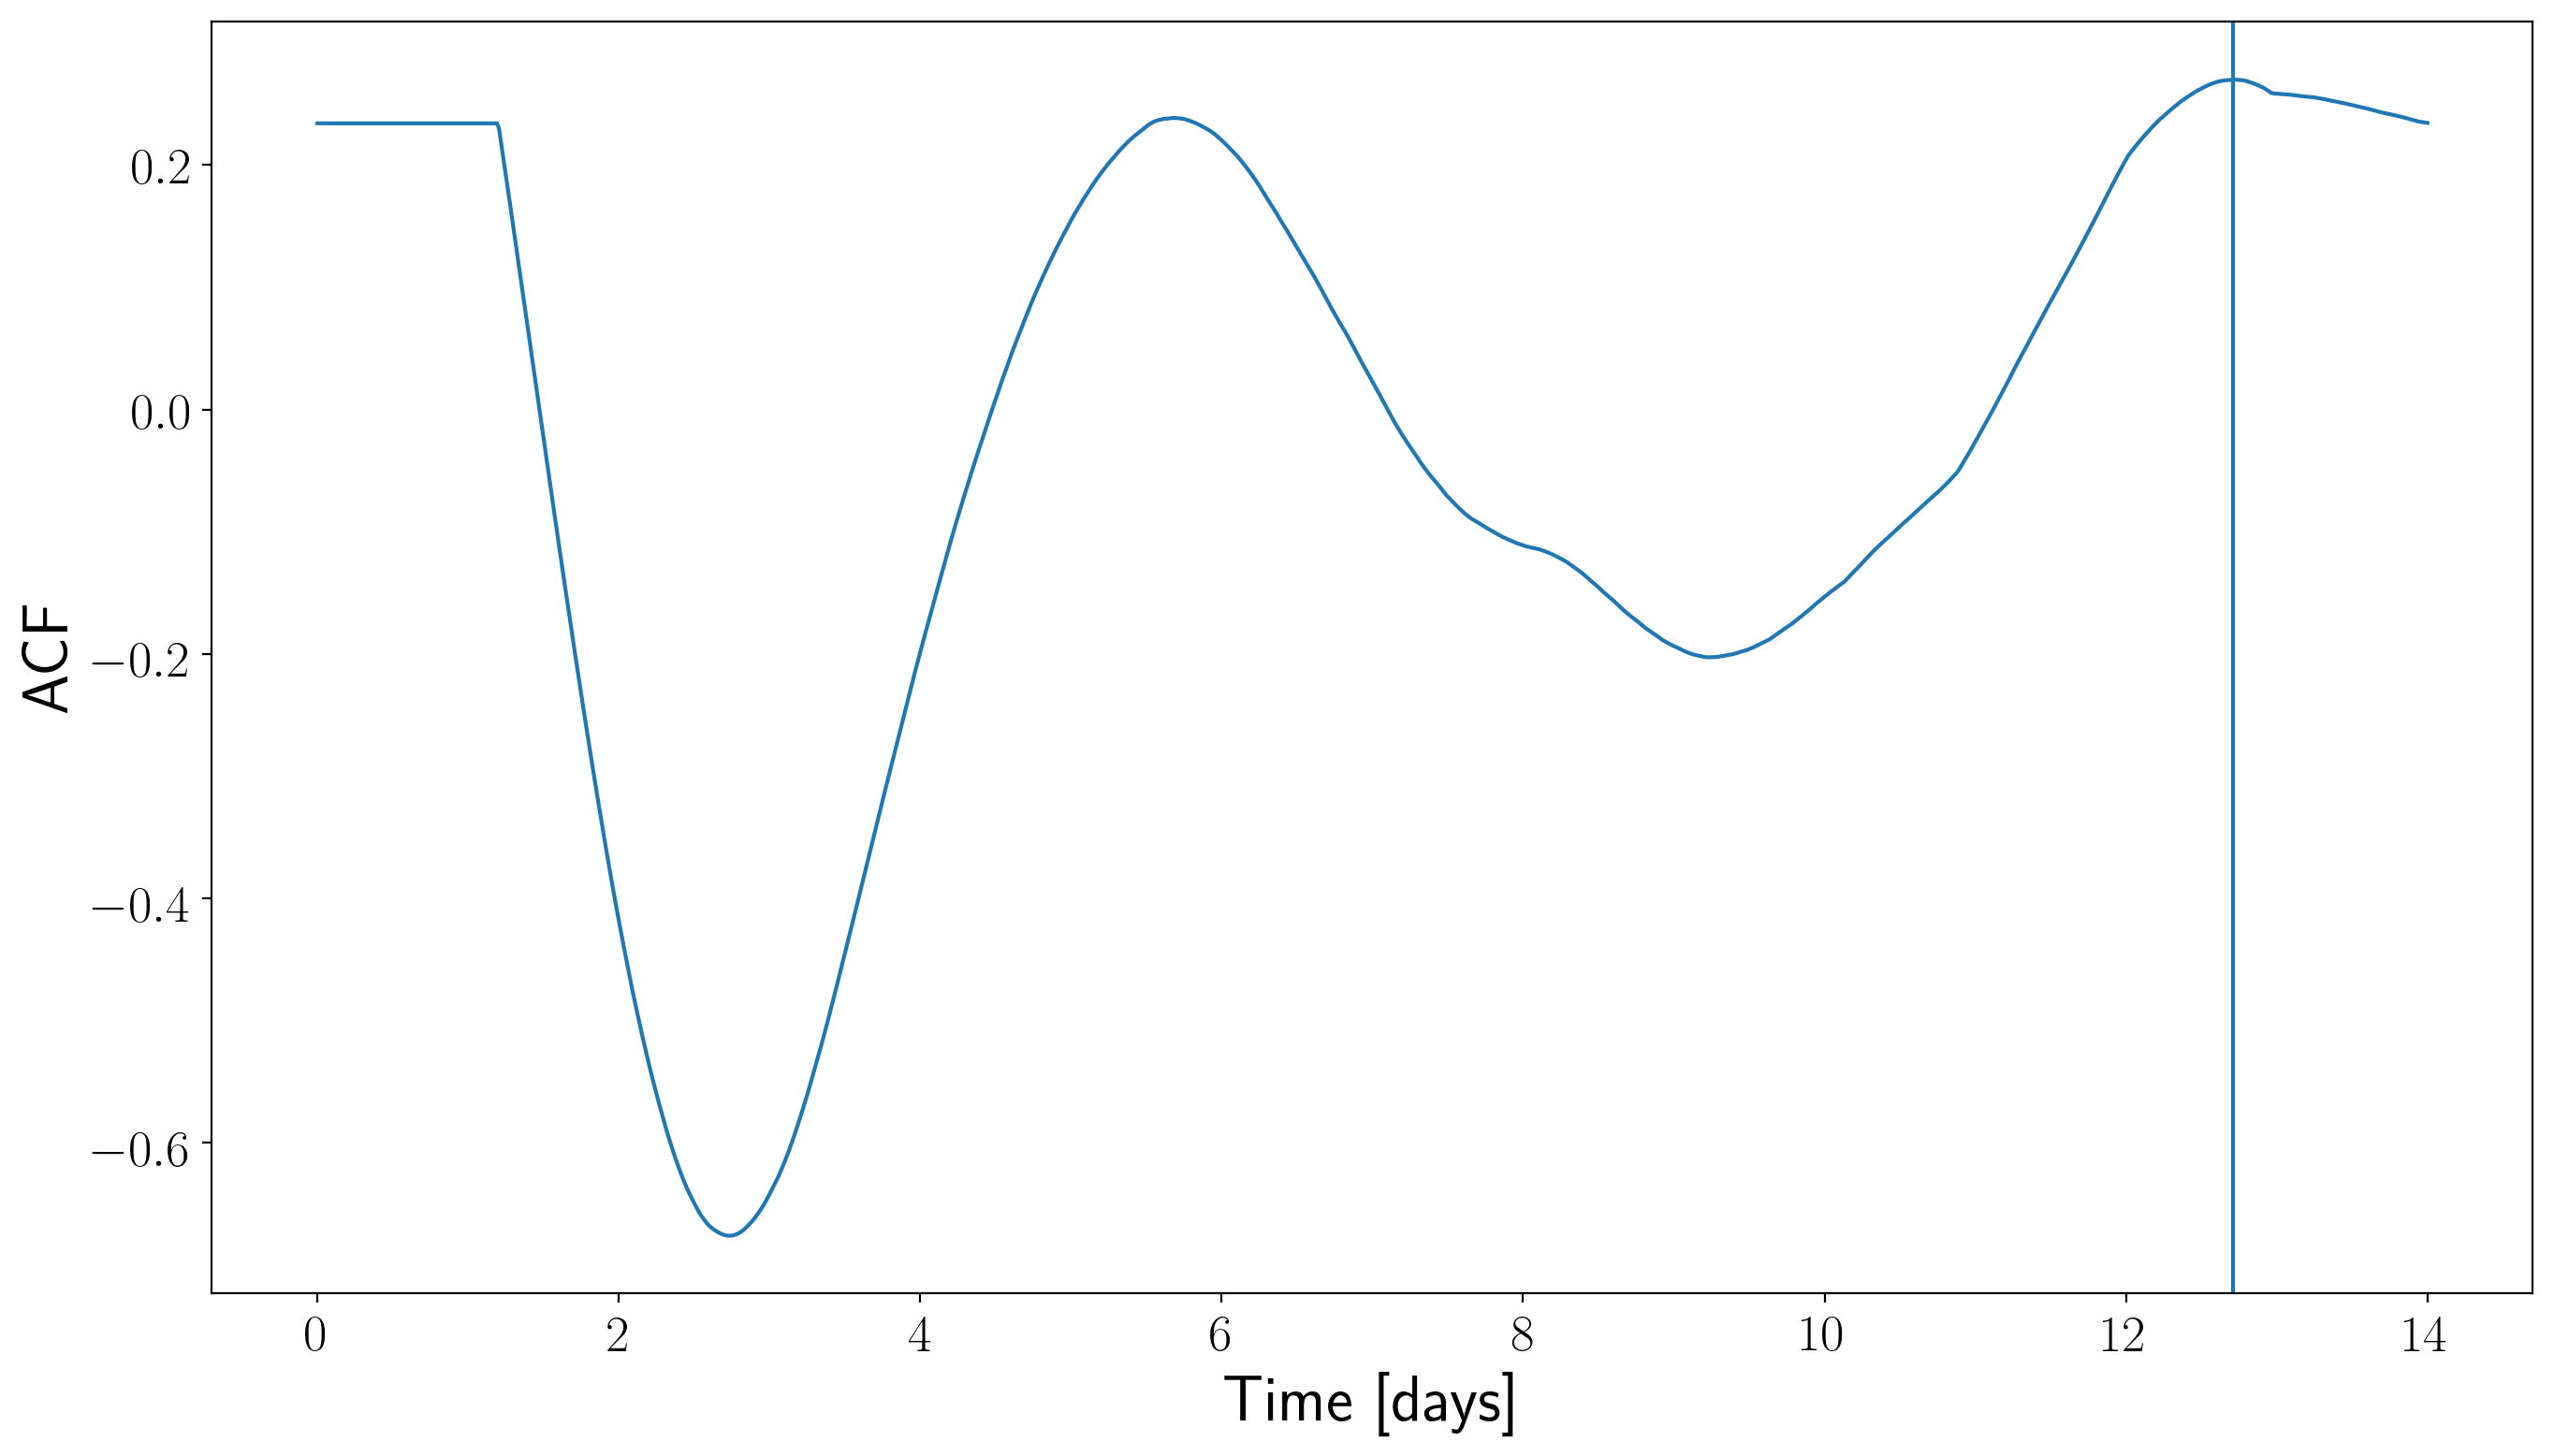

In [12]:
fig = plt.figure(figsize=(16, 9), dpi=200)
plt.plot(xp, smooth_tot, "C0")
xpeak, ypeak = get_peak_statistics(xp, smooth_tot)
plt.axvline(xpeak[0])
plt.xlabel("Time [days]")
plt.ylabel("ACF");

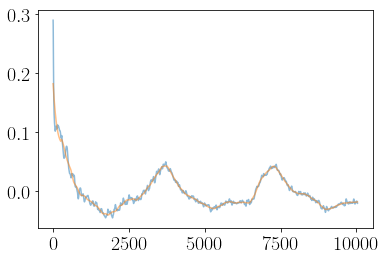